<center><h1>1-ab: SIFT & BoW</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.



- meme sift jusqu'a 1/8 cercle 
- 128 est bien plus petit que l'image / patch de base 16x16

In [ ]:
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
!unzip TP1-2-data.zip

!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/1-ab/tools.py

--2021-10-11 06:19:24--  http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86446976 (82M) [application/zip]
Saving to: ‘TP1-2-data.zip’

TP1-2-data.zip      100%[===================>]  82.44M  23.5MB/s    in 3.7s    

2021-10-11 06:19:28 (22.2 MB/s) - ‘TP1-2-data.zip’ saved [86446976/86446976]

Archive:  TP1-2-data.zip
   creating: data/
   creating: data/Scene/
   creating: data/Scene/PARoffice/
 extracting: data/Scene/PARoffice/image_0091.jpg  
 extracting: data/Scene/PARoffice/image_0167.jpg  
  inflating: data/Scene/PARoffice/image_0037.jpg  
 extracting: data/Scene/PARoffice/image_0135.jpg  
 extracting: data/Scene/PARoffice/image_0015.jpg  
 extracting: data/Scene/PARoffice/image_0182.jpg  
 extracting: data/Scene/PARoffice/image_0064.jpg  
 extracting: data/Scene/PARoffice/im

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
%run 'tools.py'
from os.path import join

data_path = "data"

# Part 1 : SIFT

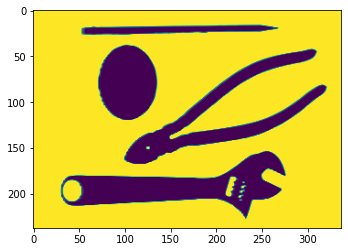

In [ ]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I)

In [ ]:
I.shape

(238, 337)

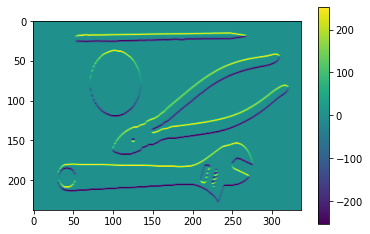

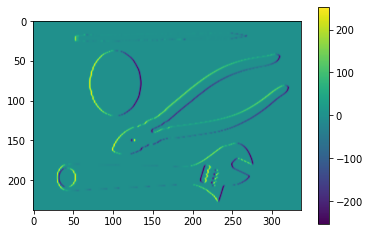

In [ ]:
def compute_grad(I):
    ha = 1/2 * np.array([1, 2, 1])
    hb = 1/2 * np.array([1, 0, -1])

    Ix = conv_separable(I, ha, hb)
    Iy = conv_separable(I, hb, ha)

    ####################
    ##      END        #
    ####################
    return Ix, Iy

# Example
Ix, Iy = compute_grad(I)
plt.imshow(Ix, cmap="viridis")
plt.colorbar()
plt.show()
plt.imshow(Iy, cmap="viridis")
plt.colorbar()
plt.show()

In [ ]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gn = np.sqrt(Ix**2 + Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gn)
    
    ####################
    ##      END        #
    ####################
    return Gn, Go


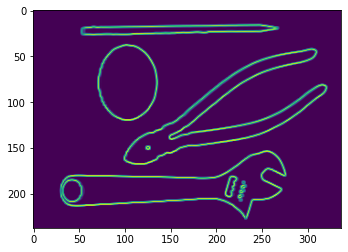

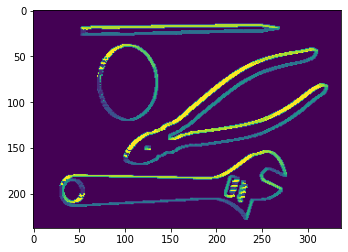

In [ ]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn, cmap="viridis")
plt.show()
plt.imshow(Go, cmap="viridis")
plt.show()

In [ ]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    hist = np.zeros((8))
    for i in range(8):
      hist[i] = g_n[g_o == i].sum()

    ####################
    ##      FIN        #
    ####################
    return hist

In [ ]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128)) 

    if mask is not None:
        Gn = Gn * mask
    
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

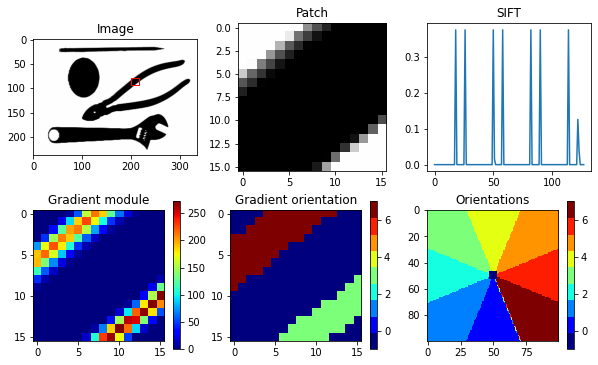

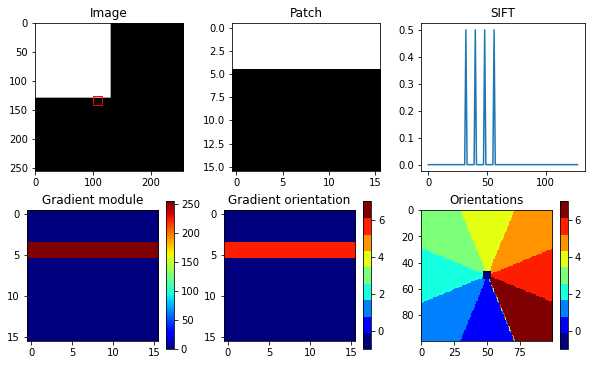

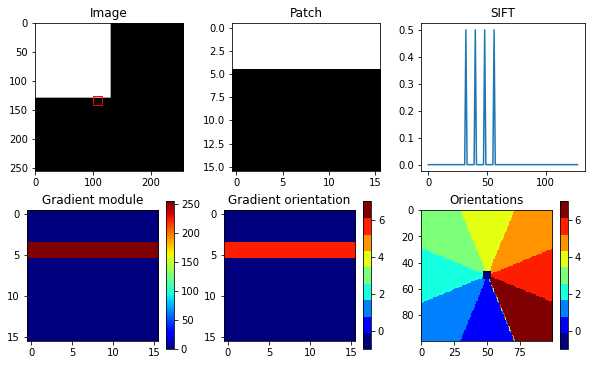

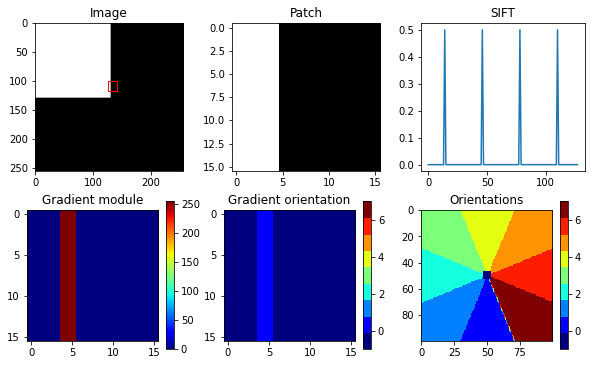

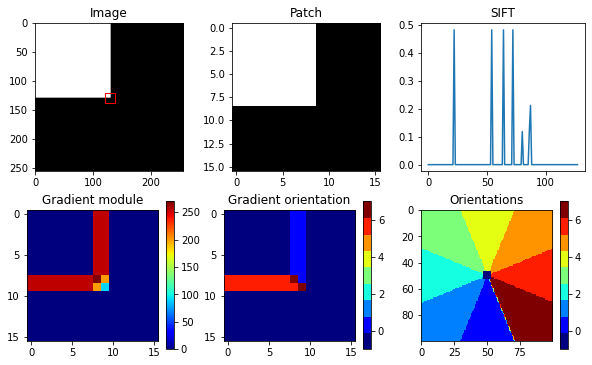

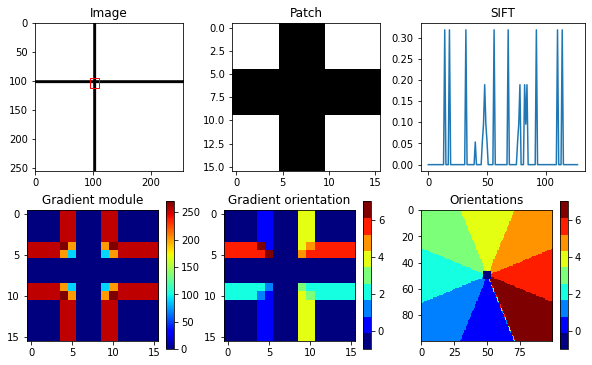

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.3181317 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05344409, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05344409, 0.09560369, 0.18864812, 0.09560369,
       0.05344409, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.3181317 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I, compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [ ]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()

    #####################
    ## Your code here  ##
    #####################
    # Here, compute on the global image (norm, gradients)
    Gn, Go = compute_grad_mod_ori(I)
   
    ####################
    ##      END        #
    ####################

    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #####################
            ## Your code here  ##
            #####################
            if xi+16 <= Gn.shape[0] and yj+16 <= Gn.shape[1]:
              sifts[i, j, :] =  compute_sift_region(Gn[xi:xi+16, yj:yj+16], Go[xi:xi+16, yj:yj+16], m) # TODO SIFT of the patch of coords (xi, yj)

            ####################
            ##      END        #
            ####################

    return sifts

# Compute SIFT

The computation can take several minutes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
max_images_per_class = None  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "/content/gdrive/My Drive/rdfia/"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs
1/4485
2/4485
3/4485
4/4485
5/4485
6/4485
7/4485
8/4485
9/4485
10/4485
11/4485
12/4485
13/4485
14/4485
15/4485
16/4485
17/4485
18/4485
19/4485
20/4485
21/4485
22/4485
23/4485
24/4485
25/4485
26/4485
27/4485
28/4485
29/4485
30/4485
31/4485
32/4485
33/4485
34/4485
35/4485
36/4485
37/4485
38/4485
39/4485
40/4485
41/4485
42/4485
43/4485
44/4485
45/4485
46/4485
47/4485
48/4485
49/4485
50/4485
51/4485
52/4485
53/4485
54/4485
55/4485
56/4485
57/4485
58/4485
59/4485
60/4485
61/4485
62/4485
63/4485
64/4485
65/4485
66/4485
67/4485
68/4485
69/4485
70/4485
71/4485
72/4485
73/4485
74/4485
75/4485
76/4485
77/4485
78/4485
79/4485
80/4485
81/4485
82/4485
83/4485
84/4485
85/4485
86/4485
87/4485
88/4485
89/4485
90/4485
91/4485
92/4485
93/4485
94/4485
95/4485
96/4485
97/4485
98/4485
99/4485
100/4485
101/4485
102/4485
103/4485
104/4485
105/4485
106/4485
107/4485
108/4485
109/4485
110/4485
111/4485
112/4485
113/4485
114/4485
115/4485
116/4485
117/4485
118/4485
119/4485
120/4485
1

In [ ]:
sifts_list_by_image[0].shape

(28, 42, 128)

# Part 2 : Visual dictionnary

In [ ]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

In [ ]:
# Code here the `compute_visual_dict` function
from sklearn.cluster import KMeans

def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    print("ok")
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector, and return visual dict
    #####################
    ## Your code here  ##
    #####################
    zeros_vect = np.zeros((128))
    kmeans = KMeans(n_clusters=n_clusters).fit(sift)
    centers = kmeans.cluster_centers_
    np.append(centers, zeros_vect)

    vdict = centers
    
    ####################
    ##      END        #
    ####################
    return vdict


In [ ]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)
print(vdict.shape)

Computing or loading visual dict
(1000, 128)


['livingroom/image_0172.jpg', 'MITstreet/image_0098.jpg', 'industrial/image_0235.jpg', 'MITcoast/image_0104.jpg', 'kitchen/image_0075.jpg', 'MITstreet/image_0160.jpg', 'MITmountain/image_0110.jpg', 'MITinsidecity/image_0058.jpg', 'livingroom/image_0283.jpg', 'MITcoast/image_0061.jpg', 'MITopencountry/image_0147.jpg', 'MITmountain/image_0041.jpg', 'PARoffice/image_0128.jpg', 'MIThighway/image_0170.jpg', 'MITstreet/image_0204.jpg', 'MITcoast/image_0188.jpg', 'MITtallbuilding/image_0148.jpg', 'industrial/image_0081.jpg', 'MITopencountry/image_0168.jpg', 'CALsuburb/image_0063.jpg', 'kitchen/image_0012.jpg', 'MITopencountry/image_0237.jpg', 'MITopencountry/image_0253.jpg', 'kitchen/image_0027.jpg', 'MITmountain/image_0297.jpg', 'MITcoast/image_0224.jpg', 'CALsuburb/image_0235.jpg', 'MITmountain/image_0267.jpg', 'MITopencountry/image_0298.jpg', 'MITstreet/image_0211.jpg']
(31820, 128)
(128,)


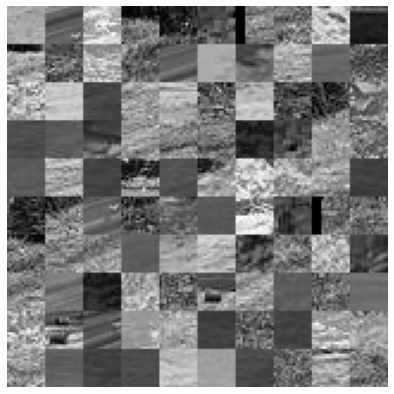

(128,)


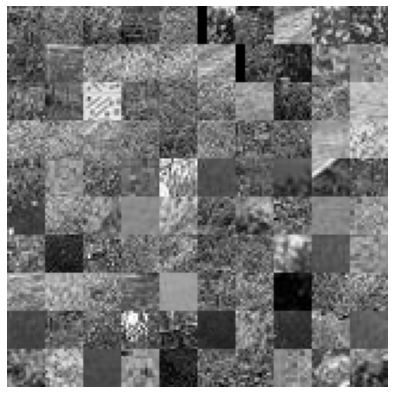

(128,)


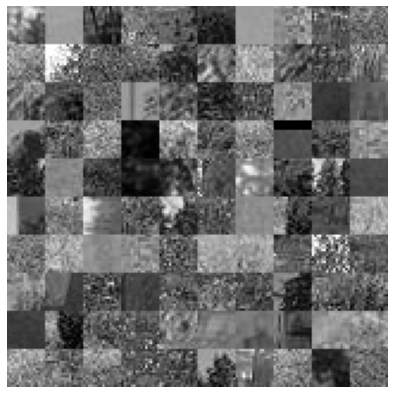

(128,)


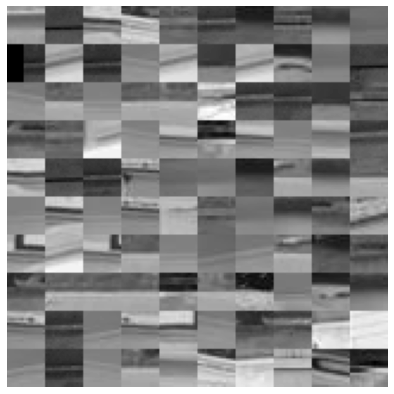

(128,)


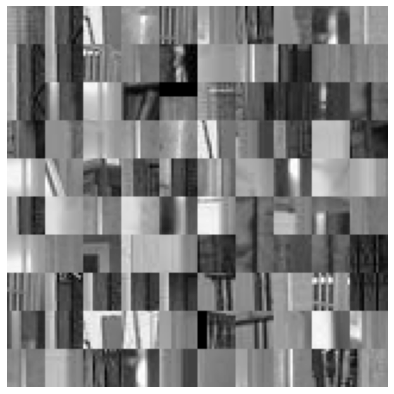

(128,)


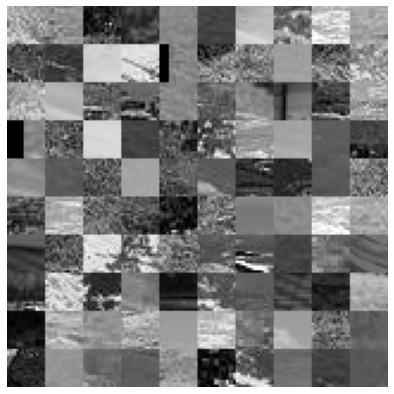

(128,)


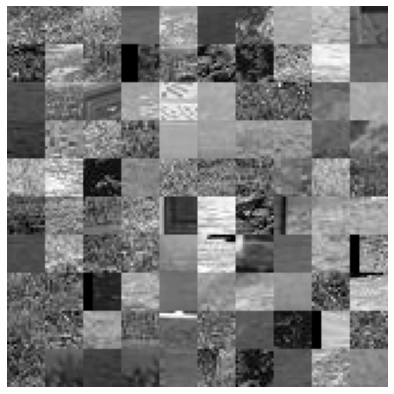

(128,)


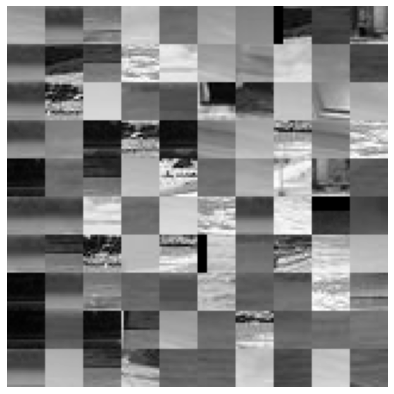

(128,)


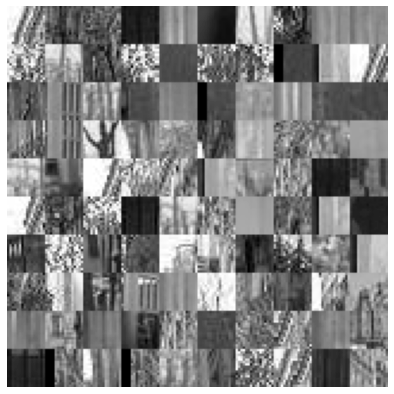

(128,)


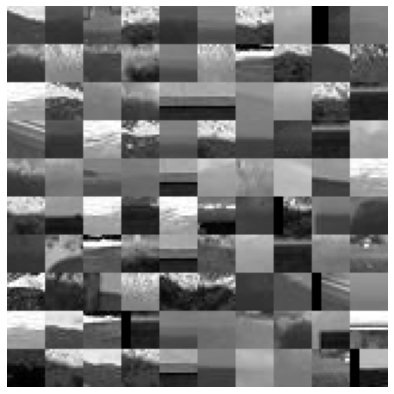

(128,)


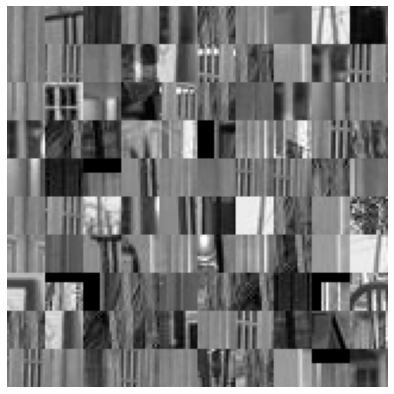

(128,)


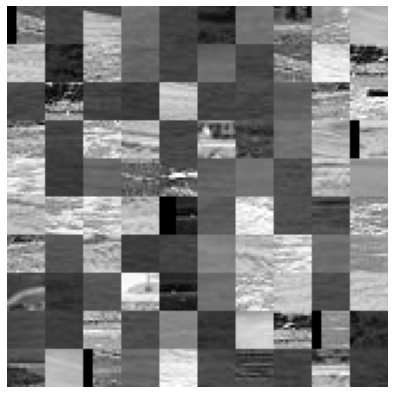

(128,)


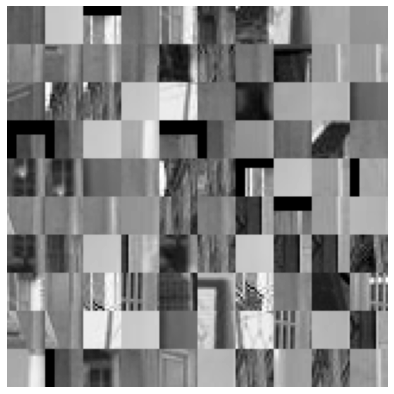

(128,)


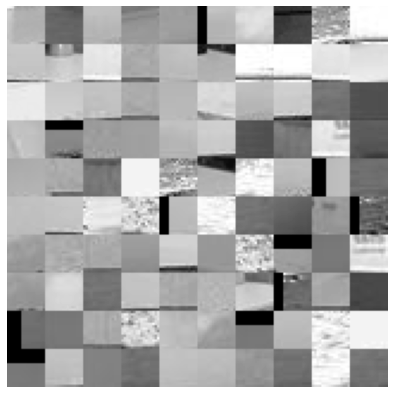

(128,)


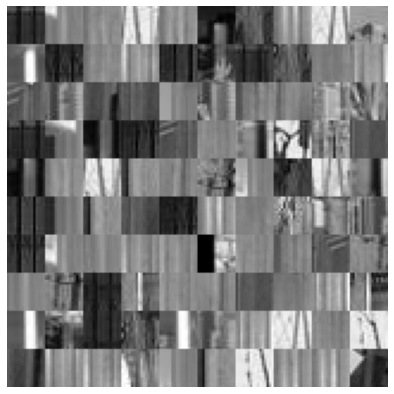

(128,)


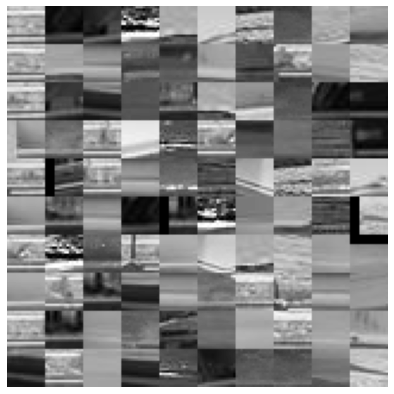

(128,)


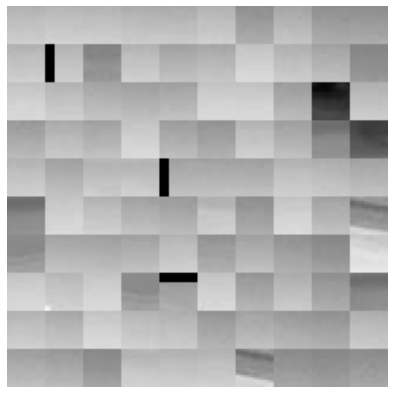

(128,)


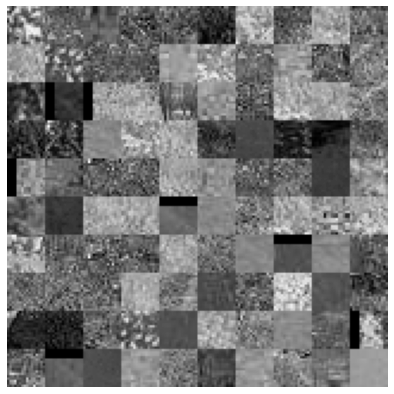

(128,)


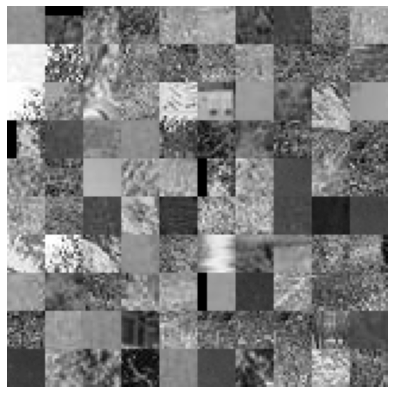

(128,)


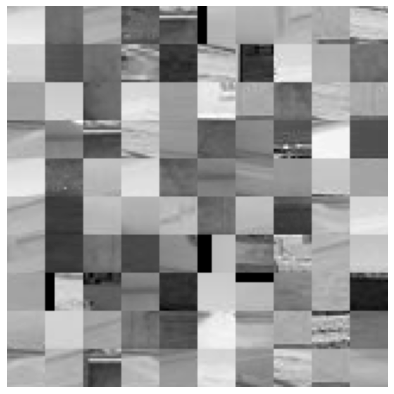

In [ ]:
# Study of the dict

# choose random images
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]
print(chosen_inames)
regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
# display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions
print(sifts.shape)
centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  print(center_vect.shape)
  dist = ((sifts - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions

(1, 16, 16)


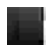

In [ ]:
center = 0
center_vect = vdict[center]
dist = ((sifts - center_vect)**2).sum(axis=1)
top50 = dist.argsort()[-1:]
top50_regions = regions[top50]
print(top50_regions.shape)
display_images(top50_regions) 

# Partie 3 : BoW

In [ ]:
# TODO Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    
    ##################### 
    ## Your code here  ##
    #####################
    # compute distance from image sifts to vdict
    H = distance_matrix(sifts, vdict)
    arg_mins = np.argmin(H, axis = 1)
    H1 = np.zeros((H.shape))
    for i in range(H1.shape[0]):
        H1[i, arg_mins[i]] = 1
    feats = H1.sum(axis=0)
    feats /=  np.linalg.norm(feats, ord=2)
    ####################
    ##      END        #
    ####################
    return feats

15 -> assigning 1 cluster to a patch
other way => More than 1 neightboor

other pooling => take max value max pooling


L2 norm => beause of nb of sift != for != images
ex : size != => nb sift tres diff

L1 => same ?


(1000,)


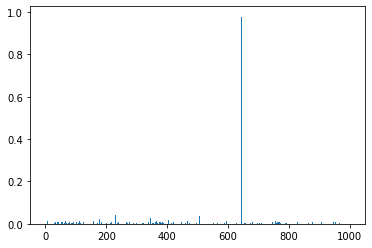

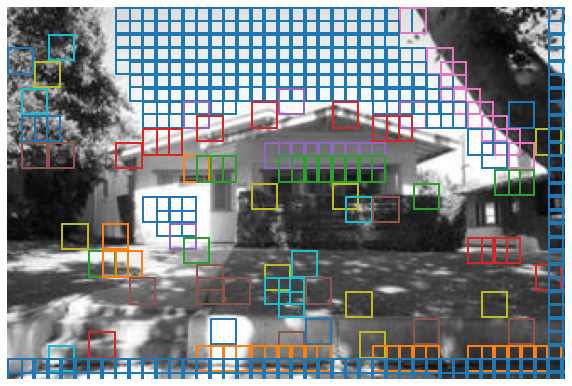

(9, 16, 16)


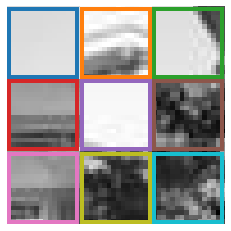

In [ ]:
# Visualize your BoW on an image

iname = inames[1]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
sift = (sift * 255).astype('uint8')
regions = compute_regions(im)
feats = compute_feats(vdict, sift)
print(feats.shape)
display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here